# File Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from netCDF4 import dataset
import scipy as sp
import xarray as xr
import datetime
import pysmile
import pysmile_license
import pickle
from sklearn.cluster import KMeans
import folium
import scipy as sp
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

# Load data

In [2]:
# The Tairua data changes before July 2014. Beforehand it's SPADS ShoreFor

In [3]:
df_tairua_data = pd.read_csv('data/inputs_target.csv')

In [4]:
df_tairua_data

,Datetime,Hs,Tp,Wvx,Wvy,yout
0,1999-01-08,0.556500,12.965625,12.898386,15.428129,60.126000
1,1999-01-09,0.481375,9.498875,7.120211,12.991844,60.511857
2,1999-01-10,0.759750,8.594000,6.069786,11.928320,60.056429
3,1999-01-11,0.855750,10.223250,7.617306,14.005734,59.582286
4,1999-01-12,1.096500,8.587125,6.436866,11.744081,59.036143
...,...,...,...,...,...,...
6562,2016-12-26,0.606375,9.291250,7.355509,12.485741,69.191571
6563,2016-12-27,0.507875,10.256000,10.076220,12.353687,69.354143
6564,2016-12-28,0.406125,10.256000,9.899607,12.565136,69.379000
6565,2016-12-29,0.393500,10.313375,10.013756,12.588981,69.266286


In [5]:
df_tairua_data = df_tairua_data.set_index('Datetime')

In [6]:
df_tairua_data.index = [datetime.datetime(int(x.split('-')[0]),int(x.split('-')[1]),int(x.split('-')[2])) for x in df_tairua_data.index]

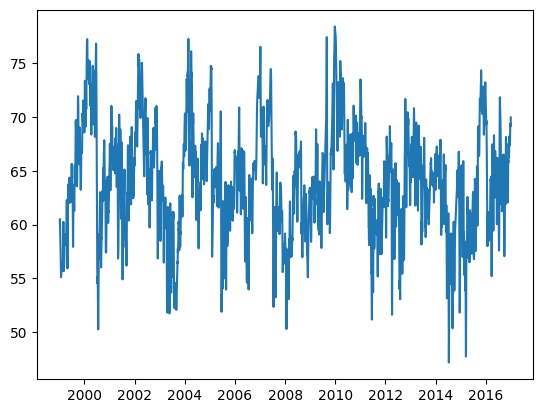

In [7]:
plt.plot(df_tairua_data.yout)

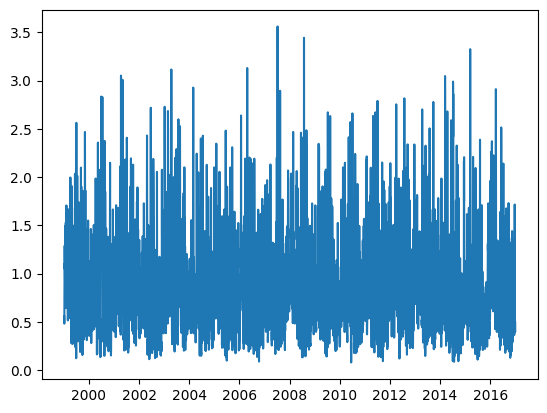

In [8]:
plt.plot(df_tairua_data.Hs)

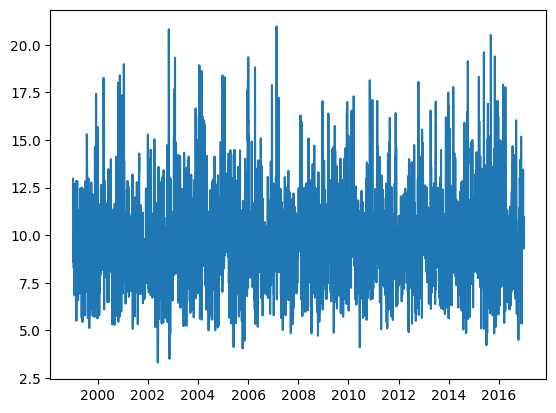

In [9]:
plt.plot(df_tairua_data.Tp)

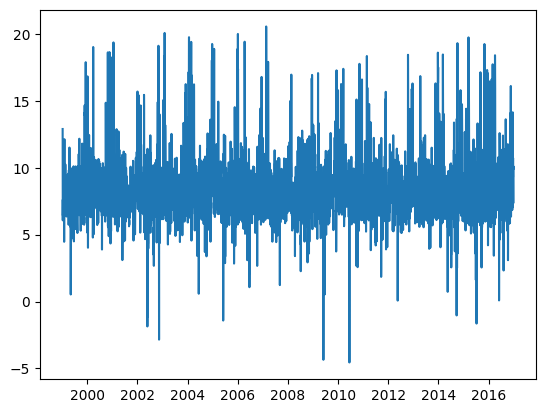

In [10]:
plt.plot(df_tairua_data.Wvx)

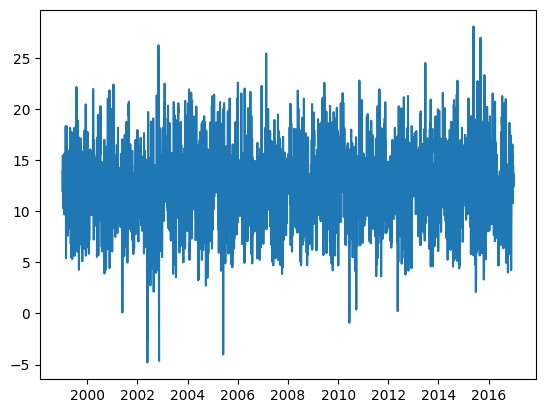

In [11]:
plt.plot(df_tairua_data.Wvy)

#### Create a new variable looking at the shoreline change between timestep

In [12]:
df_tairua_data['yout_change'] = [np.nan]+[x-y for x,y in zip(df_tairua_data.yout[1:],df_tairua_data.yout[:-1])]
df_tairua_data.dropna(inplace=True)

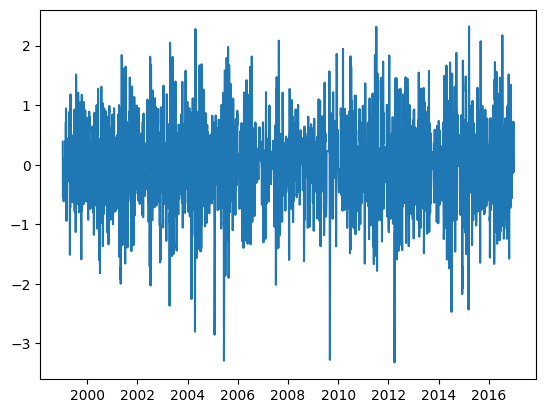

In [13]:
plt.plot(df_tairua_data.yout_change)

In [14]:
print(f'\
      Min: {np.min(df_tairua_data.yout_change)}\
      Max: {np.max(df_tairua_data.yout_change)}\
      Mean: {np.mean(df_tairua_data.yout_change)}\
      Median: {np.median(df_tairua_data.yout_change)}\
      ')

      Min: -3.319999999999993      Max: 2.3198571428571455      Mean: 0.001499369043992866      Median: 0.030857142857140474      


Timescale is per day, and the maximum movement we see is a few metres.
Generally, there isn't on average erosion or accretion, suggesting that over a long period of time, the coast is stable.

# Correlations

In [15]:
df_tairua_data.corr()

,Hs,Tp,Wvx,Wvy,yout,yout_change
Hs,1.000000,-0.072469,-0.012644,-0.053770,-0.293928,-0.266918
Tp,-0.072469,1.000000,0.623420,0.930763,0.033639,0.069140
Wvx,-0.012644,0.623420,1.000000,0.336597,0.164772,0.005616
Wvy,-0.053770,0.930763,0.336597,1.000000,-0.036308,0.071509
yout,-0.293928,0.033639,0.164772,-0.036308,1.000000,0.061988
yout_change,-0.266918,0.069140,0.005616,0.071509,0.061988,1.000000


### Creating new wave variables

#### Putting in a time lag

In [16]:
days_list = [3,7,30,90,180,365]
for days in days_list:
    for index,row in df_tairua_data.iterrows():
        df_tairua_data.loc[index,f'Hs_{days}day_mean'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'Hs'].mean()
        df_tairua_data.loc[index,f'Hs_{days}day_p95'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'Hs'].quantile(0.95)
        # Find the mean period of all waves exceeding the 95th percentile significant wave height
        df_tairua_data.loc[index,f'Tp_waves_over_{days}days_95p'] = \
        df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))&(df_tairua_data.Hs>=df_tairua_data.loc[index,f'Hs_{days}day_p95'])),"Tp"].mean()

        # df_tairua_data.loc[index,f'yout_{days}day_mean'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'yout'].mean()
        
        df_tairua_data.loc[index,f'Wvx_{days}day_mean'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'Wvx'].mean()
        df_tairua_data.loc[index,f'Wvx_{days}day_p95'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'Wvx'].quantile(0.95)
        
        df_tairua_data.loc[index,f'Wvy_{days}day_mean'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'Wvy'].mean()
        df_tairua_data.loc[index,f'Wvy_{days}day_p95'] = df_tairua_data.loc[((df_tairua_data.index<index)&(df_tairua_data.index>(index-datetime.timedelta(days=days)))),'Wvy'].quantile(0.95)
        

In [48]:
df_tairua_data['yout_lag'] = df_tairua_data['yout'].shift(1)

In [49]:
df_tairua_data = df_tairua_data.dropna()

In [50]:
df_tairua_data.corr()[['yout']].sort_values(by='yout')

,yout
Hs_90day_p95,-0.478566
Hs_180day_mean,-0.415896
Hs_180day_p95,-0.401940
Hs_90day_mean,-0.382501
Hs_30day_p95,-0.369851
Hs_7day_p95,-0.362671
Tp_waves_over_180days_95p,-0.346344
Hs_7day_mean,-0.342508
Hs_3day_p95,-0.332603
Hs_3day_mean,-0.330545


Autocorrelation in the data is high, and seems to (generally) decrease as the lag period is increased.

Let's create some lag features, and then let's use a random forest to look at feature importance

#### Look at a linear relationship between the variables

In [51]:
model = ols("yout ~ Hs_90day_p95 + Tp_waves_over_90days_95p", data=df_tairua_data).fit()
print(model.params)
print(model.summary())

Intercept                   81.426316
Hs_90day_p95                -7.655640
Tp_waves_over_90days_95p    -0.421176
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   yout   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     1026.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:10:05   Log-Likelihood:                -19072.
No. Observations:                6564   AIC:                         3.815e+04
Df Residuals:                    6561   BIC:                         3.817e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025 

Using a linear model, adding the period of the respective maximum waves doesn't add any skills for predicting yout_change

For yout, adding the period doesn't really add that much more skill, but for some time periods it is noticable (between 0.05 and 0.1 R2 values increase)

# Random Forest

Just do one testing-training split to start with for the random forest

Starting off with removing the lag variables (should be included, but it needs to be predicted lag rather than actual)

Also, super important to remove the change variable, since that's just another way of expressing the target variable yout

In [52]:
# df_tairua_data_filtered = df_tairua_data[[x for x in list(df_tairua_data) if 'yout_' not in x]]
df_tairua_data_filtered = df_tairua_data[[x for x in list(df_tairua_data) if 'yout_change' not in x]]

In [53]:
df_training = df_tairua_data_filtered[:int(len(df_tairua_data_filtered)*0.6)]
df_testing = df_tairua_data_filtered[~df_tairua_data_filtered.index.isin(df_training.index)]

In [54]:
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
vr = VotingRegressor([('rf',RandomForestRegressor()),('gb',GradientBoostingRegressor())])

target_variable = 'yout'

X_training = df_training[[x for x in list(df_training) if x!=target_variable]]
Y_training = df_training[target_variable]

X_testing = df_testing[[x for x in list(df_testing) if x!=target_variable]]
Y_testing = df_testing[target_variable]

# rf.fit(X_training,Y_training)
# gb.fit(X_training,Y_training)
vr.fit(X_training,Y_training)

VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('gb', GradientBoostingRegressor())])

In [69]:
vr_predictions = []
for index,row in X_testing.iterrows():
    if index==X_testing.index[0]:
        vr_prediction = Y_training[(index-datetime.timedelta(days=1))] # Initialise with actual previous variable
        print('initialise')
    row['yout_lag'] = vr_prediction
    vr_prediction = vr.predict(pd.DataFrame(row).T)[0]
    vr_predictions.append(vr_prediction)

initialise


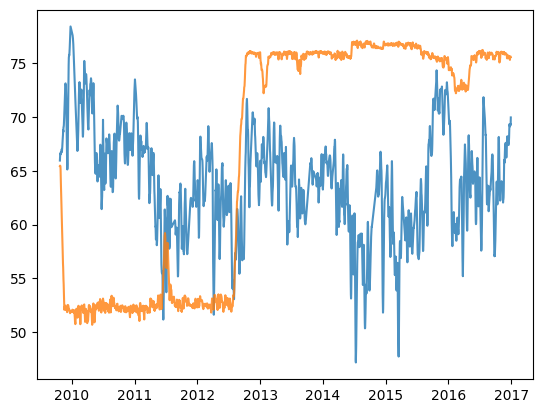

In [70]:
# plt.plot(X_testing.index,rf_predictions,alpha=0.5)
# plt.plot(X_testing.index,gb_predictions,alpha=0.5)
plt.plot(X_testing.index,Y_testing,alpha=0.8)
plt.plot(X_testing.index,vr_predictions,alpha=0.8)

In [25]:
# Solving how to encorporate autocorrealtion without data leakage

In [26]:
df_training.

SyntaxError: invalid syntax (1414617219.py, line 1)

# Setup BN

In [ ]:
df_nanumea_all_cluster

In [ ]:
df_nanumea_TOB['date

In [ ]:
pd.options.mode.chained_assignment = None
summary_results_dict = {}
true_positive_results_dict = {}
true_negative_results_dict = {}
false_positive_results_dict = {}
false_negative_results_dict = {}

individual_results_list = []


for cluster_selected in wave_node_values_per_clust.keys():
    for test_year in np.unique(df_nanumea_TOB.year2):
        if test_year==2005:
            continue
        df_waves_one_cluster = wave_node_values_per_clust[cluster_selected].copy()
        df_waves_one_cluster.columns = [y+str(x) for (x,y) in list(df_waves_one_cluster)]
        # df_waves_one_cluster = df_waves_one_cluster[[x for x in df_waves_one_cluster if (x in ['maxx'+str(x) for x in pos_selected_nodes_dict[cluster_selected]])|(x in ['minn'+str(x) for x in neg_selected_nodes_dict[cluster_selected]])]]
        df_nanumea_all_cluster = df_nanumea_TOB.set_index('position').join(pd.DataFrame.from_dict(clust_dict,orient='index'))[['intersect_distance','previous','year2',0]]
        df_nanumea_all_cluster = df_nanumea_all_cluster.reset_index()
        df_nanumea_all_cluster.columns = ['position','TOB','previous','year2','cluster']
        df_nanumea_one_cluster = df_nanumea_all_cluster[df_nanumea_all_cluster.cluster==cluster_selected]
        df_nanumea_one_cluster.drop('cluster',axis=1,inplace=True)
        df_nanumea_one_cluster = df_nanumea_one_cluster.set_index('year2').join(df_waves_one_cluster)
        df_nanumea_one_cluster = df_nanumea_one_cluster.reset_index().rename(columns={'index':'year2'}).set_index(['year2','position'])
        
        shoreline_threshold = 5
        # Discretised the results
        tob_list = []
        for index,row in df_nanumea_one_cluster.iterrows():
            if row.TOB<-shoreline_threshold:
                val = 'erosion'
            elif row.TOB>shoreline_threshold:
                val = 'accretion'
            else:
                val = 'stable'
            tob_list.append(val)
        df_nanumea_one_cluster['TOB'] = tob_list

        previous_list = []
        for index,row in df_nanumea_one_cluster.iterrows():
            if row.previous<-shoreline_threshold:
                val = 'erosion'
            elif row.previous>shoreline_threshold:
                val = 'accretion'
            else:
                val = 'stable'
            previous_list.append(val)
        df_nanumea_one_cluster['previous'] = previous_list

        parameter_cols = [x for x in list(df_nanumea_one_cluster) if ('minn'in x)|('maxx'in x)]


        p33 = df_nanumea_one_cluster[parameter_cols].quantile(0.33) #0.33
        p67 = df_nanumea_one_cluster[parameter_cols].quantile(0.67) #0.67

        for col in parameter_cols:
            val_list = []
            for index,row in df_nanumea_one_cluster.iterrows():
                if (row[col]<p33[col]):
                    val = "low"
                elif (row[col]>=p33[col])&(row[col]<=p67[col]):
                    val = "mid"
                elif (row[col]>=p67[col]):
                    val = "high"
                else:
                    print('binning error')

                val_list.append(val)
            df_nanumea_one_cluster[col] = val_list

        # Create pysmile network
        net = pysmile.Network()

        for col in list(df_nanumea_one_cluster):
            net.add_node(pysmile.NodeType.CPT,col)
            for val in np.unique(df_nanumea_one_cluster[col]):
                net.add_outcome(col,val)
            for delete_outcome in ['State0','State1']:
                net.delete_outcome(col,delete_outcome)

        for col in list(df_nanumea_one_cluster):
            if col!='TOB':
                net.add_arc('TOB',col)

        # format ready for pySMILE
        df_training = df_nanumea_one_cluster[df_nanumea_one_cluster.index.get_level_values(0)!=test_year]
        df_testing = df_nanumea_one_cluster[df_nanumea_one_cluster.index.get_level_values(0)==test_year]
        df_training.reset_index(drop=True,inplace=True)
        df_testing.reset_index(drop=True,inplace=True)

        # Training the BN
        df_training.to_csv('Processed_data_and_output/training_data.csv',index=False)
        ds_training = pysmile.learning.DataSet()
        ds_training.read_file('Processed_data_and_output/training_data.csv')

        em = pysmile.learning.EM()
        em.learn(data=ds_training,net=net,matching=ds_training.match_network(net))

        net.write_file(f"Processed_data_and_output/network_{cluster_selected}_{test_year}.xdsl")

        net.clear_all_evidence()

        node_id = net.get_node('TOB')

        children = net.get_child_ids('TOB')

        results_dict = {}
        for index,row in df_testing.iterrows():
            for child in children:
                child_outcomes = net.get_outcome_ids(child)
                child_evidence_dict = {}
                for child_outcome in child_outcomes:
                    if child_outcome==row[child]:
                        val=1
                    else:
                        val=0
                    child_evidence_dict.update({
                        child_outcome:val
                    })

                evidence_list = [child_evidence_dict[x] for x in child_outcomes]
                net.set_virtual_evidence(child,evidence_list)

            # Update beliefs
            net.update_beliefs()
            predictions = {outcome:val for outcome,val in zip(net.get_outcome_ids('TOB'),net.get_node_value('TOB'))}
            row['most_likely_state'] = max(predictions, key= lambda x: predictions[x])
            results_dict.update({
                index:row.append(pd.Series(predictions))
            })

        df_testing_results = pd.DataFrame.from_dict(results_dict).T
        df_testing_results['position'] = list(df_nanumea_one_cluster.reset_index().loc[df_nanumea_one_cluster.reset_index().year2==test_year,'position'])
        df_testing_results['year2'] = test_year
        
        individual_results_list.append(df_testing_results)
        
        for state in ['erosion','accretion','stable']:
            true_positive = len(df_testing_results[(df_testing_results['TOB']==state)&(df_testing_results['most_likely_state']==state)])
            true_negative = len(df_testing_results[(df_testing_results['TOB']!=state)&(df_testing_results['most_likely_state']!=state)])
            false_positive = len(df_testing_results[(df_testing_results['TOB']!=state)&(df_testing_results['most_likely_state']==state)])
            false_negative = len(df_testing_results[(df_testing_results['TOB']==state)&(df_testing_results['most_likely_state']!=state)])

            summary_results_dict.update({
                (state,test_year,cluster_selected):len(df_testing_results[df_testing_results['TOB']==df_testing_results['most_likely_state']])/len(df_testing_results)
            })

            true_positive_results_dict.update({
                (state,test_year,cluster_selected):true_positive
            })

            false_positive_results_dict.update({
                (state,test_year,cluster_selected):false_positive
            })

            true_negative_results_dict.update({
                (state,test_year,cluster_selected):true_negative
            })

            false_negative_results_dict.update({
                (state,test_year,cluster_selected):false_negative
            })
            


In [ ]:
df_nanumea_one_cluster

In [ ]:
df_nanumea_one_cluster

In [ ]:
df_testing_results = pd.DataFrame.from_dict(results_dict).T


In [ ]:
df_true_positive_results = pd.DataFrame.from_dict(true_positive_results_dict,orient='index')
df_false_positive_results = pd.DataFrame.from_dict(false_positive_results_dict,orient='index')
df_true_negative_results = pd.DataFrame.from_dict(true_negative_results_dict,orient='index')
df_false_negative_results = pd.DataFrame.from_dict(false_negative_results_dict,orient='index')


In [ ]:
# 
df_true_negative_results['state'] = [x[0] for x in df_true_negative_results.index]
df_true_negative_results['year'] = [x[1] for x in df_true_negative_results.index]
df_true_negative_results['clust'] = [x[2] for x in df_true_negative_results.index]

df_true_positive_results['state'] = [x[0] for x in df_true_positive_results.index]
df_true_positive_results['year'] = [x[1] for x in df_true_positive_results.index]
df_true_positive_results['clust'] = [x[2] for x in df_true_positive_results.index]

df_false_negative_results['state'] = [x[0] for x in df_false_negative_results.index]
df_false_negative_results['year'] = [x[1] for x in df_false_negative_results.index]
df_false_negative_results['clust'] = [x[2] for x in df_false_negative_results.index]

df_false_positive_results['state'] = [x[0] for x in df_false_positive_results.index]
df_false_positive_results['year'] = [x[1] for x in df_false_positive_results.index]
df_false_positive_results['clust'] = [x[2] for x in df_false_positive_results.index]


In [ ]:
df_results = pd.DataFrame.from_dict(summary_results_dict,orient='index').reset_index()
df_results['state'] = [x[0] for x in df_results['index']]
df_results['year'] = [x[1] for x in df_results['index']]
df_results['clust'] = [x[2] for x in df_results['index']]
df_results.columns = ['index','accuracy','state','year','clust']
df_results.drop('index',axis=1,inplace=True)

In [ ]:
df_results

In [ ]:
round(df_results.groupby('year').mean(),2)[['accuracy']]
# Should compare to if 'stable' is not considered as wrong


In [ ]:
round(df_results.groupby('clust').mean(),2)[['accuracy']]

In [ ]:
# erosion
true_negative = df_true_negative_results.loc[(df_true_negative_results.state=='erosion'),0].sum()
true_positive = df_true_positive_results.loc[(df_true_positive_results.state=='erosion'),0].sum()
false_negative = df_false_negative_results.loc[(df_false_negative_results.state=='erosion'),0].sum()
false_positive = df_false_positive_results.loc[(df_false_positive_results.state=='erosion'),0].sum()

print('true negative',true_negative)
print('true positive',true_positive)
print('false negative',false_negative)
print('false positive',false_positive)
print('')
print('True Positive Rate')
print(true_positive/(true_positive+false_negative))
print('')
print('True Negative Rate')
print(true_negative/(true_negative+false_positive))
print('')
print('F-score')
print(true_positive/(true_positive+0.5*(false_positive+false_negative)))


In [ ]:
# stable
true_negative = df_true_negative_results.loc[(df_true_negative_results.state=='stable'),0].sum()
true_positive = df_true_positive_results.loc[(df_true_positive_results.state=='stable'),0].sum()
false_negative = df_false_negative_results.loc[(df_false_negative_results.state=='stable'),0].sum()
false_positive = df_false_positive_results.loc[(df_false_positive_results.state=='stable'),0].sum()

print('true negative',true_negative)
print('true positive',true_positive)
print('false negative',false_negative)
print('false positive',false_positive)
print('')
print('True Positive Rate')
print(true_positive/(true_positive+false_negative))
print('')
print('True Negative Rate')
print(true_negative/(true_negative+false_positive))
print('')
print('F-score')
print(true_positive/(true_positive+0.5*(false_positive+false_negative)))


In [ ]:
# accretion
true_negative = df_true_negative_results.loc[(df_true_negative_results.state=='accretion'),0].sum()
true_positive = df_true_positive_results.loc[(df_true_positive_results.state=='accretion'),0].sum()
false_negative = df_false_negative_results.loc[(df_false_negative_results.state=='accretion'),0].sum()
false_positive = df_false_positive_results.loc[(df_false_positive_results.state=='accretion'),0].sum()

print('true negative',true_negative)
print('true positive',true_positive)
print('false negative',false_negative)
print('false positive',false_positive)
print('')
print('True Positive Rate')
print(true_positive/(true_positive+false_negative))
print('')
print('True Negative Rate')
print(true_negative/(true_negative+false_positive))
print('')
print('F-score')
print(true_positive/(true_positive+0.5*(false_positive+false_negative)))
